In [1]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../cow.py
%run ../optimize_pkg.py

In [3]:
filepath_down = "../data_tables/hs_rs_downlink/n"
filepath_up = "../data_tables/hs_rs_uplink/n"

In [5]:
protocol_target = 10**(-9)
rx_SNR_range = arange(0, 12, 0.1)
tx_SNR_range = arange(5, -10*log10(protocol_target), 0.01)
protocolbit = 4*10**4
start_node, end_node = 2, 36
user_range = arange(start_node, end_node, 1)

## Optimize 3

In [6]:
%%time
filepath_down = "../data_tables/hs_rs_downlink/n"
filepath_up = "../data_tables/hs_rs_uplink/n"

optimize_3_data = zeros((34, 5))
rx_SNR_start = -1
d_actual_SNR = 1
tx_SNR_range = arange(12, 50, 0.1)
for N in user_range:
    optimize_3_data[N-user_range[0]] = optimize_3(N, rx_SNR_start, tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, optimize_3_data[N-user_range[0]]
    
# print optimize_3_data

2 [  4.74000000e+01   0.00000000e+00   3.46504057e-21   1.31067068e-11
   1.31067068e-11]
3 [  3.42000000e+01   0.00000000e+00   6.25178513e-19   1.90343646e-07
   1.90343646e-07]
4 [  2.72000000e+01   1.00000000e+00   2.13663220e-50   7.74306133e-14
   7.74306133e-14]
5 [  2.28000000e+01   1.00000000e+00   5.11849896e-46   1.59367810e-10
   1.59367810e-10]
6 [  2.08000000e+01   2.00000000e+00   1.06512976e-93   6.80487300e-17
   6.80487300e-17]
7 [  1.86000000e+01   2.00000000e+00   3.34237860e-87   2.28382042e-14
   2.28382042e-14]
8 [  1.69000000e+01   2.00000000e+00   6.84895214e-81   1.79269191e-11
   1.79269191e-11]
9 [  1.58000000e+01   2.00000000e+00   1.24872137e-75   4.88241156e-10
   4.88241156e-10]
10 [  1.55000000e+001   3.00000000e+000   2.73429275e-132   1.69747638e-014
   1.69747638e-014]
11 [  1.46000000e+001   3.00000000e+000   1.43466523e-123   1.09438634e-012
   1.09438634e-012]
12 [  1.39000000e+001   3.00000000e+000   2.98180582e-116   6.84675633e-011
   6.8467563

# XOR Analysis

Search for tSNR, rSNR1, rSNR2, rSNR3

$$h_1 = 10^{\frac{rSNR1 - tSNR}{10}} $$
same for $h_2$, $h_3$

Assume rSNR1 = rSNR2, therefore h1 = h2 therefore $p_{f1} = p_{f2}$

$$p_{f1} = 1 - \text{exp }(-h1)$$

$G_c =$ nodes with good fade to Controller  
- Note: if you're good in downlink you're good in uplink because reciprocity, but not necessarily good in XOR because of different thresholds  
E = everyone else

$\tilde{A_d}$ The set of nodes that is ultimately successful  
- $\tilde{A_{ds}}$ Fade good enough for XOR threshold
- $\tilde{A_{di}}$ Fade good enough for DU but not good enough for XOR
- - If XOR h < DU h then $\tilde{A_{di}}$ will be empty

$\hat{A_d}$ has downlink message but uplink failed because of additive noise
- $\hat{A_{ds}} \;, \; \hat{A_{di}}$

$\tilde{B_u}$ failed in downlink but has uplink messages (of itself and potentially other slaves)

$\hat{B_u}$ Fade is good but additive noise was bad both times (slave $\leftrightarrow$ controller), in XOR this set can't talk and succeed alone (because _both_ downlink and uplink won't happen)  

Note: the controller can talk if it can XOR, timeslots are allotted per node

## P(states)

$$ P(G_c = g_c) = {N \choose gc} \left(1 - p_{f1} \right)^{g_c} \left( p_{f1} \right)^{N - g_c}$$

$$ \left[ {g_c \choose a_d} \left( 1 - p_{a1} \right)^{a_d} \left( p_{a1} \right)^{g_c - a_d} \right] \cdot
\left[ {a_d \choose \tilde{a_d}} \left( 1 - p_{a2} \right)^{\tilde{a_d}} \left( p_{a2} \right)^{a_d - \tilde{a_d}} \right] \cdot
\left[ {b_u \choose \tilde{b_u}} \left( 1 - p_{a2} \right)^{\tilde{b_u}} \left( p_{a2} \right)^{b_u - \tilde{b_u}} \right]$$

$$ a_d = \tilde{a_d} + \hat{a_d} $$
$$ b_u = \tilde{b_u} + \hat{b_u} $$

Recall
$$ {\tilde{a_d} \choose \tilde{a_{ds}}} \left(1 - p_{f3} \right)^{\tilde{a_{ds}}} \left( p_{f3} \right)^{\tilde{a_d} - \tilde{a_{ds}}} = {\tilde{a_d} \choose \tilde{a_{ds}}} \left(1 - p_{f3} \right)^{\tilde{a_{ds}}} \left( p_{f3} \right)^{\tilde{a_{di}}} $$
$$ {\hat{a_d} \choose \hat{a_{ds}}} \left(1 - p_{f3} \right)^{\hat{a_{ds}}} \left( p_{f3} \right)^{\hat{a_d} - \hat{a_{ds}}} $$

$$ P(h \leq h_3 | h \geq h_1 ) = \frac{ P(h_1 \leq h \leq h_3)}{ P(h_1 \leq h)} = \left\{ \begin{array}{cc}
0 & h_3 \leq h_1 \\
1 - \text{exp }(h_1 - h_3) & h_3 > h_1
\end{array} \right. $$

$ \tilde{A}_{ds}$ has succeeded
$$ q^{\tilde{a}_{ds}} = 0 $$

$\hat{A}_{ds}$ will succeed if additive noise 3 is good
$$ q^{\hat{a}_{ds}} = p_{a3} $$

$\hat{A}_{di}$ will succeed if connect to $\left( \tilde{A}_{ds} \cup \hat{A}_{ds} \right)$ in uplink and additive noise is good
- $\left( \tilde{A}_{ds} \cup \hat{A}_{ds} \right)$ have the downlink message, so they can XOR and talk to the controller in XOR phase
$$ q^{\hat{a}_{di}} = p_2^{a_{ds}} + (1 - p_2)^{a_{ds}} p_{a3} $$
- First part: all slave links failed
- Second part: at least 1 slave-slave link succeeded but additive noise killed the node

$\tilde{B}_u$ will succeed if either:
- Controller is loud in XOR
- $A_d$ heard node in $\tilde{B}_u$ and is loud in XOR
$$ S^{\tilde{B}_u} = (1 - p_{f3} ) + p_{f3} \left[ \sum_{k=1}^{a_d} {a_d \choose k} (1 - p_2)^k p_2^{a_d - k} (1 - p_{f3}^k ) \right] $$
$$ q_{\tilde{b}_u} = (1 - S^{\tilde{b}_u} ) + S^{\tilde{b}_u} p_{a3} $$

Everyone else will succeed if they connect in uplink to a node in $A_{ds}$ and in downlink to any node in $A_d$  
Connect to $K_s A_{ds}$ nodes and/or $K_i A_{di}$ nodes
$$ F_e = p_2^{a_{ds}} + \left[ \sum_{k_s = 1}^{a_{ds}} {a_{ds} \choose k_s} (1 - p_2)^{k_s} p_2^{a_d - k_s} p_{f3}^{k_s} \right] \cdot \left[ \sum_{k_i = 0}^{a_{di}} {a_{di} \choose k_i} (1 - p_2)^{k_i} p_2^{a_d - k_i} p_{f3}^{k_i} \right] $$
- First part: can't connect in uplink to a supreme set node
- Second part: will fail if connection for downlink is bad given connected to $k_s$ and $k_i$, due to fade the msg still didn't reach weak node ("no link")
$$ q_e = F_e + (1 - F_e) \left[ 1 - (1 - p_{a3})^2 \right] $$
Even if link established, additive noise can strike at both controller and weak node (you can fail at either place)

$$ \text{P(success)} = \sum_{\text{states}} P(\text{states}) \left( 1 - q^{\hat{a}_{ds}} \right)^{\hat{a}_{ds}} \left( 1 - q^{\hat{a}_{di}} \right)^{\hat{a}_{di}} \left( 1 - q^{\tilde{b}_u} \right)^{\tilde{b}_u} \left( 1 - q_e \right)^{N - a_d - \tilde{b}_u} $$

CPU times: user 143 ms, sys: 11.6 ms, total: 155 ms
Wall time: 158 ms


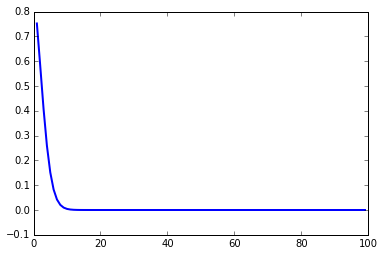

In [156]:
%%time
%run ../optimize_pkg.py
# xor_analysis_opt(N, p_add_3, nom_SNR, actual_SNR)
SNR = range(1, 100)
# print rSNR
pfail = zeros((5, 99))
for n in range(1, 6, 1):
    psuccess = [xor_analysis_opt(n, 10**(-9), snr, 1) for snr in SNR]
    pfail[n-1] = 1 - array(psuccess)
# print pfail[0]
plot(SNR, pfail[3], lw=2.0)
# print z

[  7.52119383e-01   5.81701639e-01   4.07054572e-01   2.59115913e-01
   1.51618701e-01   8.25428607e-02   4.23074949e-02   2.06352166e-02
   9.66629049e-03   4.38259668e-03   1.93551846e-03   8.36988227e-04
   3.55900593e-04   1.49313815e-04   6.19749860e-05   2.55049946e-05
   1.04251798e-05   4.23834713e-06   1.71572886e-06   6.92197960e-07
   2.78523089e-07   1.11844245e-07   4.48476786e-08   1.79685044e-08
   7.19923854e-09   2.88819180e-09   1.16284393e-09   4.71850004e-10
   1.94470995e-10   8.25377544e-11   3.68783892e-11   1.78600468e-11
   9.63051860e-12   5.83455506e-12   3.91153776e-12   2.81907830e-12
   2.12463380e-12   1.64190883e-12   1.28619337e-12   1.01441078e-12
   8.02913291e-13   6.36712905e-13   5.05262499e-13   4.01123579e-13
   3.18522986e-13   2.53130850e-13   2.00950367e-13   1.59650071e-13
   1.26898492e-13   1.00697228e-13   8.01581024e-14   6.35047570e-14
   5.04041253e-14   4.00790512e-14   3.18634008e-14   2.53130850e-14
   2.00950367e-14   1.59872116e-14

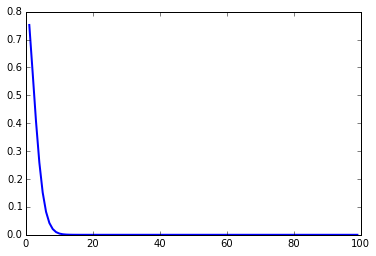

In [157]:
%%time
%run ../optimize_pkg_2.py
SNR = range(1, 100)
# xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
pfail_2 = zeros((5, 99))
for n in range(1, 6, 1):
    psuccess_2 = [xor_analysis_new(n, snr, 1, 1) for snr in SNR]
    pfail_2[n-1] = 1 - array(psuccess_2)
print pfail_2[3]
plot(SNR, pfail_2[3], lw=2.0)

[ -6.32120578e-10  -5.48115331e-10  -4.67917927e-10  -3.94189015e-10
  -3.28409966e-10  -2.71106582e-10  -2.22124319e-10  -1.80881199e-10
  -1.46567869e-10  -1.18290377e-10  -9.51625445e-11  -7.63599184e-11
  -6.11464213e-11  -4.88834528e-11  -3.90286692e-11  -3.11279891e-11
  -2.48059351e-11  -1.97548644e-11  -1.57239777e-11  -1.25103261e-11
  -9.95015181e-12  -7.91178234e-12  -6.28963548e-12  -4.99933428e-12
  -3.97315514e-12  -3.15725224e-12  -2.50865995e-12  -1.99329442e-12
  -1.58362212e-12  -1.25810473e-12  -9.99422767e-13  -7.94031507e-13
  -6.30717700e-13  -5.01043651e-13  -3.98014954e-13  -3.16191517e-13
  -2.51132448e-13  -1.99507078e-13  -1.58428826e-13  -1.25899291e-13
  -9.99200722e-14  -7.93809463e-14  -6.30606678e-14  -5.00710584e-14
  -3.97459843e-14  -3.16413562e-14  -2.50910404e-14  -1.98729921e-14
  -1.57651669e-14  -1.25455202e-14]


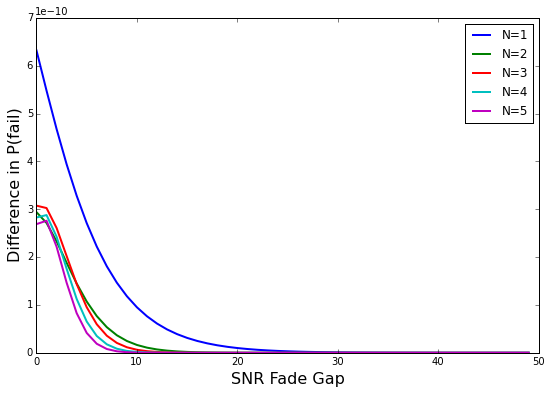

In [164]:
print pfail[0,:50] - pfail_2[0,:50]
figure(figsize=(9, 6))
for n in range(1, 6, 1):
    plot(array(SNR[:50]) - 1, abs(pfail[n-1,:50] - pfail_2[n-1,:50]), lw=2.0, label='N={}'.format(n))
xlabel('SNR Fade Gap', fontsize=16)
ylabel('Difference in P(fail)', fontsize=16)
legend(loc=0)
savefig('diff_between_analysis_50.pdf', bbox='tight')
# title('N = 2', fontsize=20)

# Short Blocklength Test

In [50]:
protocol_target = 10**(-9)
rx_SNR_range = arange(0, 12, 0.01)
# tx_SNR_range = arange(30, -10*log10(protocol_target), 0.01)
protocolbit = 4200
start_node, end_node = 2, 6
user_range = arange(start_node, end_node, 1)

In [51]:
filepath_down = "../data_tables/short_block_test/default/down/n"
filepath_up = "../data_tables/short_block_test/default/up/n"

## Old Optimize 1

In [112]:
%%time
%run ../optimize_pkg.py
optimize_1_data = zeros((5, 5))
tx_SNR_range = arange(32, 60, 0.01)
for N in user_range:
    optimize_1_data[N-1] = optimize_1(N, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up, protocolbit)

CPU times: user 787 ms, sys: 6.18 ms, total: 794 ms
Wall time: 799 ms


In [113]:
print optimize_1_data

[[    0.       0.       0.       0.       0.  ]
 [   50.94     3.55  1400.    1400.    1400.  ]
 [   38.65     5.31  1400.    1400.    1400.  ]
 [   34.44     8.29  1400.    1400.    1400.  ]
 [   32.92    11.18  1400.    1400.    1400.  ]]


## New Optimize 1

In [115]:
%%time
%run ../optimize_pkg_2.py
optimize_1_data_2 = zeros((5, 7))
tx_SNR_range = arange(32, 60, 0.01)
for N in user_range[::-1]:
    optimize_1_data_2[N-1] = optimize_1(N, tx_SNR_range, filepath_down, filepath_up, protocolbit)
    print N, optimize_1_data_2[N-1]

5 [  3.29200000e+01   1.11800000e+01   1.09100000e+01   1.09100000e+01
   9.41287048e-11   9.55602264e-11   9.55602264e-11]
4 [  3.44400000e+01   5.05000000e+00   8.29000000e+00   8.29000000e+00
   9.50248074e-11   9.82982445e-11   9.82982445e-11]
3 [  3.86500000e+01   3.34000000e+00   5.31000000e+00   5.31000000e+00
   8.67846335e-11   9.57194967e-11   9.57194967e-11]
2 [  5.09400000e+01   2.44000000e+00   3.55000000e+00   3.55000000e+00
   8.60089696e-11   9.48693257e-11   9.48693257e-11]
CPU times: user 4min 25s, sys: 948 ms, total: 4min 26s
Wall time: 4min 29s


In [109]:
print optimize_1_data_2

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.10000000e+01   2.44000000e+00   3.55000000e+00   3.55000000e+00
    8.60089696e-11   9.48693257e-11   9.48693257e-11]
 [  3.87000000e+01   3.34000000e+00   5.31000000e+00   5.31000000e+00
    8.67846335e-11   9.57194967e-11   9.57194967e-11]
 [  3.45000000e+01   5.05000000e+00   8.29000000e+00   8.29000000e+00
    9.50248074e-11   9.82982445e-11   9.82982445e-11]
 [  3.30000000e+01   1.11800000e+01   1.09100000e+01   1.09100000e+01
    9.41287048e-11   9.55602264e-11   9.55602264e-11]]


## New Optimize 3

In [58]:
%%time
%run ../optimize_pkg_2.py
optimize_3_data_2 = zeros((5, 6))
tx_SNR_range = arange(28, 60, 1)
for N in user_range[::-1]:
    optimize_3_data_2[N-1] = optimize_3(N, rx_SNR_start, tx_SNR_range, filepath_down, filepath_up, protocolbit, 1)
    print N, optimize_3_data_2[N-1]

<string>:84: RuntimeWarning: divide by zero encountered in log10


KeyboardInterrupt: 

In [67]:
rv = binom(3, 1)
print rv.pmf(3)

1.0


In [76]:
pf3 = 1
range(0 if pf3 else 5, 6)

[0, 1, 2, 3, 4, 5]

In [105]:
0.532082170106 + 5.32082155058e-10
0.532082171639 > 0.532082171171
10**-4.342944698377123e-10 * 10**-9.0000000122826869
9.99999998e-10 * 10**-0.27402129302407713

5.320821701064214e-10

[  7.52119383e-01   5.81701639e-01   4.07054572e-01   2.59115913e-01
   1.51618701e-01   8.25428607e-02   4.23074949e-02   2.06352166e-02
   9.66629049e-03   4.38259668e-03   1.93551846e-03   8.36988227e-04
   3.55900593e-04   1.49313815e-04   6.19749860e-05   2.55049946e-05
   1.04251798e-05   4.23834713e-06   1.71572886e-06   6.92197960e-07
   2.78523089e-07   1.11844245e-07   4.48476786e-08   1.79685044e-08
   7.19923854e-09   2.88819180e-09   1.16284393e-09   4.71850004e-10
   1.94470995e-10   8.25377544e-11   3.68783892e-11   1.78600468e-11
   9.63051860e-12   5.83455506e-12   3.91153776e-12   2.81907830e-12
   2.12463380e-12   1.64190883e-12   1.28619337e-12   1.01441078e-12
   8.02913291e-13   6.36712905e-13   5.05262499e-13   4.01123579e-13
   3.18522986e-13   2.53130850e-13   2.00950367e-13   1.59650071e-13
   1.26898492e-13]
CPU times: user 37.8 s, sys: 620 ms, total: 38.5 s
Wall time: 40.7 s


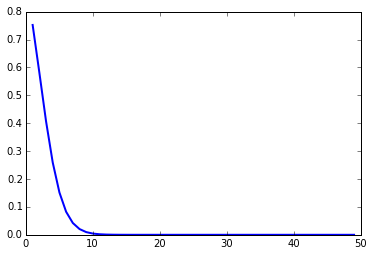

In [165]:
%%time
%run ../optimize_pkg_2.py
SNR = range(1, 50)
# xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
pfail_2 = zeros((5, 49))
for n in range(1, 6, 1):
    psuccess_2 = [xor_analysis_new(n, snr, 1, 1) for snr in SNR]
    pfail_2[n-1] = 1 - array(psuccess_2)
print pfail_2[3]
plot(SNR, pfail_2[3], lw=2.0)

## Vectorizing it for Speedup

In [227]:
%%time
%run ../optimize_pkg_2.py
# xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
n = 30
psuccess_ = xor_analysis_new(n, 20, 1, 1)
print psuccess_    

0.999999999249
CPU times: user 47.2 s, sys: 316 ms, total: 47.5 s
Wall time: 49.1 s


In [256]:
# Use this
def xor_analysis_new(N, tSNR, rSNRdu, rSNR3, p_a1=10**(-9), p_a2=10**(-9), p_a3=10**(-9)):
    if rSNRdu > tSNR: return 0
    h_du = 10**((rSNRdu - tSNR)/10) # linear fade
    h_xor = 10**((rSNR3 - tSNR)/10)
    # Probability fade is bad
    p_f1 = p_f2 = 1 - np.exp(-h_du)
    p_f3 = 1 - np.exp(h_du-h_xor) if h_xor > h_du else 0

    p_link_1 = p_f1 + (1 - p_f1) * p_a1
    p_link_2 = p_f2 + (1 - p_f2) * p_a2

    result = 0
    rv_gc = binom(N, 1 - p_f1)
    for gc in range(0, N+1):
        rv_ad = binom(gc, 1 - p_a1)
        for ad in range(0, gc+1):
            rv_ad_tilde = binom(ad, 1 - p_a2)
            bu = gc - ad
            rv_bu = binom(ad, 1-p_link_2)
            kad = np.arange(1, ad+1)
            s_bu_tilde = (1 - p_f3) + p_f3 * np.dot(rv_bu.pmf(kad), 1-np.power(p_f3, kad)) if p_f3 else 1
            # s_bu_tilde = (1 - p_f3) + p_f3 * sum([rv_bu.pmf(k) * (1 - p_f3**k) for k in range(1, ad+1)]) if p_f3 else 1
            q_bu_tilde = (1 - s_bu_tilde) + s_bu_tilde * p_a3
            for ad_tilde in range(0, ad+1):
                rv_ad_tilde_s = binom(ad_tilde, 1 - p_f3)
                rv_ad_hat_s = binom(ad - ad_tilde, 1 - p_f3)
                # if p_f3 = 0 then ad_tilde_s should = ad_tilde because ad_tilde_i should be empty
                for ad_tilde_s in range(0 if p_f3 else ad_tilde, ad_tilde+1):
                    # ad_tilde already succeeded
                    # if p_f3 = 0 then ad_hat_s should = ad - ad_tilde because ad_hat_i should be empty
                    for ad_hat_s in range(0 if p_f3 else ad-ad_tilde, ad-ad_tilde+1):
                        ad_s = ad_tilde_s + ad_hat_s
                        ad_i = ad - ad_tilde_s - ad_hat_s # ad - ad_s
                        rv_ads = binom(ad_s, 1 - p_link_2)
                        rv_adi = binom(ad_i, 1 - p_link_2)
                        q_ad_hat_s = p_a3
                        q_ad_hat_i = p_link_2**ad_s + (1 - p_link_2)**ad_s * p_a3
                        # This is the problem zone that doesn't support vectorization (?)
                        ks, ki = np.arange(1, ad_s+1), np.arange(0, ad_i+1)
                        f_e = p_link_2**ad_s + (np.dot(rv_ads.pmf(ks), np.power(p_f3, ks)) * np.dot(rv_adi.pmf(ki), np.power(p_f3, ki)) if p_f3 else 0)
                        q_e = f_e + (1 - f_e) * (1 - (1 - p_a3)**2)
                        rv_bu_tilde = binom(bu, 1 - p_a2)
                        bu_tilde = arange(0, bu+1)
                        log_pstates = np.log10(rv_gc.pmf(gc)) + np.log10(rv_ad.pmf(ad)) + np.log10(rv_ad_tilde.pmf(ad_tilde)) + np.log10(rv_ad_tilde_s.pmf(ad_tilde_s)) + np.log10(rv_ad_hat_s.pmf(ad_hat_s))
                        bu_tilde_res = np.dot(rv_bu_tilde.pmf(bu_tilde), np.multiply(np.power(1 - q_e, N-ad-bu_tilde), np.power(1 - q_bu_tilde, bu_tilde)))
                        res = 10**log_pstates * (1 - q_ad_hat_s)**ad_hat_s * (1 - q_ad_hat_i)**(ad - ad_tilde - ad_hat_s) * bu_tilde_res
                        result += res
                        # print res, result
                        # print gc, ad, ad_tilde, ad_tilde_s, ad_hat_s, bu_tilde
                        # print "\n"
    return result

In [ ]:
def xor_analysis_new(N, tSNR, rSNRdu, rSNR3, p_a1=10**(-9), p_a2=10**(-9), p_a3=10**(-9)):
    if rSNRdu > tSNR: return 0
    h_du = 10**((rSNRdu - tSNR)/10) # linear fade
    h_xor = 10**((rSNR3 - tSNR)/10)
    # Probability fade is bad
    p_f1 = p_f2 = 1 - np.exp(-h_du)
    p_f3 = 1 - np.exp(h_du-h_xor) if h_xor > h_du else 0

    p_link_1 = p_f1 + (1 - p_f1) * p_a1
    p_link_2 = p_f2 + (1 - p_f2) * p_a2

    q_ad_hat_s = p_a3
    
    result = 0
    rv_gc = binom(N, 1 - p_f1)
    for gc in range(0, N+1):
        rv_ad = binom(gc, 1 - p_a1)
        for ad in range(0, gc+1):
            rv_ad_tilde = binom(ad, 1 - p_a2)
            bu = gc - ad
            rv_bu = binom(ad, 1-p_link_2)
            kad = np.arange(1, ad+1)
            s_bu_tilde = (1 - p_f3) + p_f3 * np.dot(rv_bu.pmf(kad), 1-np.power(p_f3, kad)) if p_f3 else 1
            # s_bu_tilde = (1 - p_f3) + p_f3 * sum([rv_bu.pmf(k) * (1 - p_f3**k) for k in range(1, ad+1)]) if p_f3 else 1
            q_bu_tilde = (1 - s_bu_tilde) + s_bu_tilde * p_a3
            for ad_tilde in range(0, ad+1):
                rv_ad_tilde_s = binom(ad_tilde, 1 - p_f3)
                rv_ad_hat_s = binom(ad - ad_tilde, 1 - p_f3)
                # if p_f3 = 0 then ad_tilde_s should = ad_tilde because ad_tilde_i should be empty
                for ad_tilde_s in range(0 if p_f3 else ad_tilde, ad_tilde+1):
                    # ad_tilde already succeeded
                    # if p_f3 = 0 then ad_hat_s should = ad - ad_tilde because ad_hat_i should be empty
                    ad_hat_s = arange(0, ad-ad_tilde+1) if p_f3 else array([ad-ad_tilde])
                    ad_s = ad_tilde_s + ad_hat_s
                    ad_i = (ad_tilde - ad_tilde_s) + (ad - ad_tilde - ad_hat_s)
                    q_ad_hat_i = np.power(p_link_2, ad_s) + p_a3 * np.power(1 - p_link_2, ad_s)
#                     for ad_hat_s in range(0 if p_f3 else ad-ad_tilde, ad-ad_tilde+1):
#                         ad_s = ad_tilde_s + ad_hat_s
#                         ad_i = (ad_tilde - ad_tilde_s) + (ad - ad_tilde - ad_hat_s)
#                         q_ad_hat_i = p_link_2**ad_s + (1 - p_link_2)**ad_s * p_a3
                    rv_ads = binom(ad_s, 1 - p_link_2)
                    rv_adi = binom(ad_i, 1 - p_link_2)
                        ks, ki = np.arange(1, ad_s+1), np.arange(0, ad_i+1)
                        f_e = p_link_2**ad_s + (np.dot(rv_ads.pmf(ks), np.power(p_f3, ks)) * np.dot(rv_adi.pmf(ki), np.power(p_f3, ki)) if p_f3 else 0)
                        q_e = f_e + (1 - f_e) * (1 - (1 - p_a3)**2)
                        rv_bu_tilde = binom(bu, 1 - p_a2)
                        bu_tilde = arange(0, bu+1)
                        log_pstates = np.log10(rv_gc.pmf(gc)) + np.log10(rv_ad.pmf(ad)) + np.log10(rv_ad_tilde.pmf(ad_tilde)) + np.log10(rv_ad_tilde_s.pmf(ad_tilde_s)) + np.log10(rv_ad_hat_s.pmf(ad_hat_s))
                        bu_tilde_res = np.dot(rv_bu_tilde.pmf(bu_tilde), np.multiply(np.power(1 - q_e, N-ad-bu_tilde), np.power(1 - q_bu_tilde, bu_tilde)))
                        res = 10**log_pstates * (1 - q_ad_hat_s)**ad_hat_s * (1 - q_ad_hat_i)**(ad - ad_tilde - ad_hat_s) * bu_tilde_res
                        result += res
                        # print res, result
                        # print gc, ad, ad_tilde, ad_tilde_s, ad_hat_s, bu_tilde
                        # print "\n"
    return result

In [235]:
%%time
# xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
n = 30
psuccess_ = xor_analysis_new(n, 20, 1, 1)
print psuccess_    

0.999999999249
CPU times: user 23.4 s, sys: 250 ms, total: 23.7 s
Wall time: 24.2 s


In [243]:
0.245888256052
ks = arange(1, 5)
print ks
rv = binom(5, 0.25)
print rv.pmf(ks)
print np.power(3, ks)
rv2 = binom(0, 0.5)
print rv2.pmf(0)
print rv2.pmf(1)
z = binom(array([1, 3, 5]), 0.5)
print z.pmf(1)
z = indices((2,4))
print z
for x, y in z:
    print x, y
a, b = meshgrid(arange(0,4), arange(0,2))
print '\n'
print a, b
# for x, y in z:
#     print x,y

[1 2 3 4]
[ 0.39550781  0.26367187  0.08789062  0.01464844]
[ 3  9 27 81]
1.0
0.0
[ 0.5      0.375    0.15625]
[[[0 0 0 0]
  [1 1 1 1]]

 [[0 1 2 3]
  [0 1 2 3]]]
[0 0 0 0] [1 1 1 1]
[0 1 2 3] [0 1 2 3]


[[0 1 2 3]
 [0 1 2 3]] [[0 0 0 0]
 [1 1 1 1]]


In [253]:
rSNRdu = 7
rSNR3 = 7
tSNR = 34

h_du = 10**((rSNRdu - tSNR)/10) # linear fade
h_xor = 10**((rSNR3 - tSNR)/10)
# Probability fade is bad
p_f1 = p_f2 = 1 - np.exp(-h_du)
p_f3 = 1 - np.exp(h_du-h_xor) if h_xor > h_du else 0

print h_du
print p_f1
print h_xor
print p_f3

0.00199526231497
0.00199327310234
0.00199526231497
0


In [255]:
N = 1
tSNR = 34
rSNRdu = 7
rSNR3 = 7
print xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
tSNR = 33
print xor_analysis_new(N, tSNR, rSNRdu, rSNR3)

0.998006726898
0.997491265715


In [ ]:
%%time
%run ../optimize_pkg_2.py
# How long it takes if rSNR3 = rSNRdu, pf3 = 0
N = 10
tSNR = 14
rSNRdu = 2
rSNR3 = 3
a3 = xor_analysis_new(N, tSNR, rSNRdu, rSNR3)
print a3

In [258]:
type(binom(10, 0.5).pmf(5))

numpy.float64